In [1]:
from uuid import UUID
import sys
import logging 
import arrow
import pandas as pd
import public_data

import matplotlib.pyplot as plt
%matplotlib inline
import datetime as pydt
import emission.core.get_database as edb
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt

logging.getLogger().setLevel(logging.DEBUG)
logger = logging.getLogger()
#logger.handlers[0].stream = sys.stdout

In [2]:
#android_ids = ["70968068-dba5-406c-8e26-09b548da0e4b", "6561431f-d4c1-4e0f-9489-ab1190341fb7",
#             "92cf5840-af59-400c-ab72-bab3dcdf7818", "93e8a1cc-321f-4fa9-8c3c-46928668e45d"]
# nexus
iphone_ids = ["079e0f1a-c440-3d7c-b0e7-de160f748e35", "95e70727-a04e-3e33-b7fe-34ab19194f8b"]
# Moto
android_ids = [ "fd7b4c2e-2c8b-3bfa-94f0-d1e3ecbd5fb7", "3bc0f91f-7660-34a2-b005-5c399598a369"]

In [27]:
# pull data from the server 
server_url = 'https://e-mission.eecs.berkeley.edu'

#overall
start_ts = arrow.get('2016-10-17T13:00:00-07:00').timestamp #time in UTC
end_ts = arrow.get('2016-10-18T02:00:00-07:00').timestamp#time in UTC
print start_ts, end_ts
phone_ids = iphone_ids+android_ids

public_data.request_batched_data(server_url, start_ts, end_ts, phone_ids)

1476734400 1476781200
Data loaded to local server!


In [28]:
logger.setLevel(logging.CRITICAL)

android_ts = map(lambda u: esta.TimeSeries.get_time_series(UUID(u)), android_ids)
#time query specification
time_range = estt.TimeQuery("metadata.write_ts", start_ts, end_ts)
android_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", time_range), android_ts)
android_battery_df_list = map(lambda t:t.get_data_df("background/battery", time_range), android_ts)


iphone_ts = map(lambda u: esta.TimeSeries.get_time_series(UUID(u)), iphone_ids)
#time query specification
ios_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", time_range), iphone_ts)
iphone_battery_df_list = map(lambda t:t.get_data_df("background/battery", time_range), iphone_ts)


In [29]:
android_test = android_battery_df_list[1]
android_test[['fmt_time', 'battery_level_pct', 'battery_status']]

,fmt_time,battery_level_pct,battery_status
0,2016-10-17T13:33:00.143000-07:00,78,1
1,2016-10-17T14:03:00.357000-07:00,78,1
2,2016-10-17T14:59:07.529000-07:00,77,1
3,2016-10-17T15:03:00.210000-07:00,77,1
4,2016-10-17T17:04:04.747000-07:00,76,1
5,2016-10-17T18:00:56.726000-07:00,74,1
6,2016-10-17T18:33:00.880000-07:00,74,1
7,2016-10-17T19:03:17.284000-07:00,73,1
8,2016-10-17T19:40:57.049000-07:00,73,2
9,2016-10-17T20:32:58.727000-07:00,97,2


In [30]:
import numpy as np

android_xnew = np.arange(start_ts, end_ts, 15 * 60) # 15 minutes
# android_xnew2 = np.arange(start_ts2, end_ts2, 15 * 60) # 15 minutes

In [31]:
import scipy.interpolate as spi
import numpy as np

def get_interpolated(x, y, xnew):
    # fn = spi.interp1d(x=x, y=y, bounds_error=False, fill_value=y.iloc[-1])
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    return fn(xnew)
def get_interpolated_df(sensor_df, xnew):
    local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
    fmt_time_new = map(lambda dt: dt.isoformat(), local_dt_new)
    interpolated_series = get_interpolated(sensor_df.ts, sensor_df.battery_level_pct, xnew)
    interpolated_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'fmt_time': fmt_time_new, 'battery_level_pct': interpolated_series})
    return interpolated_df

In [32]:
android_battery_interp_df_list = map(lambda df: get_interpolated_df(df, android_xnew), android_battery_df_list)
iphone_battery_interp_df_list = map(lambda df: get_interpolated_df(df, android_xnew), iphone_battery_df_list)

In [33]:
ig_start_ts = arrow.get('2016-10-17T18:00:00-07:00').timestamp #time in UTC
ig_end_ts = arrow.get('2016-10-17T20:30:00-07:00').timestamp#time in UTC

In [34]:
sel_android_battery_df_list = map(lambda df: df[np.logical_not(np.logical_and(df.ts > ig_start_ts, df.ts < ig_end_ts))], android_battery_interp_df_list)
sel_iphone_battery_df_list = map(lambda df: df[np.logical_not(np.logical_and(df.ts > ig_start_ts, df.ts < ig_end_ts))], iphone_battery_interp_df_list)

In [35]:
title = "variable workload (ios and android)"
text = "1hr,1hr,1hr,1hr"
label = ['"Nexus6"-1', '"Nexus6"-2']
label2 = ['"iPhone6"-1', '"iPhone6"-2']
#style = ['ob', 'og', 'or', 'oc']

style_interp = ['b', 'g']
style = ['ob', 'og']

style_interp2 = ['r', 'c']
style2 = ['or', 'oc']

ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)

In [36]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

About to plot 0
About to plot 1
About to plot 0
About to plot 1
About to plot 0
About to plot 1
About to plot 0
About to plot 1


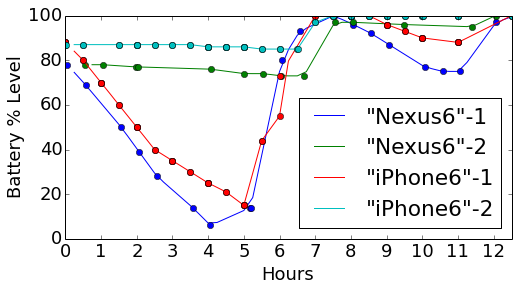

In [39]:
#Android: With interplation on battery data 

(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(8,4))
iaxes = iaxes2d

#ifig.suptitle(title + ' (Android_overlaid)', fontsize=14, fontweight='bold')

for i, df in enumerate(android_battery_interp_df_list):
    print "About to plot %d" % i
    df['hr'] = (df.ts-start_ts)/3600.0
    df['min'] = (df.ts-start_ts)/60.0
    df.plot(x='hr', y='battery_level_pct', style=style_interp[i], ax=iaxes, label= label[i], legend=True)


for i, df in enumerate(android_battery_df_list):
    print "About to plot %d" % i
    df['hr'] = (df.ts-start_ts)/3600.0
    df['min'] = (df.ts-start_ts)/60.0
    df.plot(x='hr', y='battery_level_pct', style=style[i], ax=iaxes,  xlim=(min(df.hr), max(df.hr)), legend=False)
    iaxes.set_xlabel('Hours')
    iaxes.set_ylabel('Battery Level')
    #plt.xticks(np.arange(min(df.dt), max(df.dt), 1))
    

for i, df in enumerate(iphone_battery_interp_df_list):
    print "About to plot %d" % i
    df['hr'] = (df.ts-start_ts)/3600.0
    df['min'] = (df.ts-start_ts)/60.0
    df.plot(x='hr', y='battery_level_pct', style=style_interp2[i], ax=iaxes, label=label2[i], legend=True)


for i, df in enumerate(iphone_battery_df_list):
    print "About to plot %d" % i
    df['hr'] = (df.ts-start_ts)/3600.0
    df['min'] = (df.ts-start_ts)/60.0
    df.plot(x='hr', y='battery_level_pct', style=style2[i], ax=iaxes,  xlim=(min(df.hr), max(df.hr)), legend=False)
    iaxes.set_xlabel('Hours')
    iaxes.set_ylabel('Battery % Level')
    plt.xticks(np.arange(min(df.hr), max(df.hr), 1))


ifig.savefig('../graphs/parallel_validity_variable_workload_slow.pdf')

In [40]:
from scipy import stats


total=[]
print "From linear model fitting ..." 
for i, df in enumerate(android_battery_interp_df_list):
    notnull = df.battery_level_pct.notnull()
    slope, intercept, r_value, p_value, std_err = stats.linregress(df.hr[notnull], df.battery_level_pct[notnull])
    print "Nexus 7 %d: " % (i+1)  + "slope="+str(slope) + " %/hr  std_err="+str(std_err)
    total.append(slope)

print "average slope=" + str(sum(total)/len(total)) + " %/hr  std dev=" + str(np.std(total))



From linear model fitting ...
Nexus 7 1: slope=-0.156200621626 %/hr  std_err=0.0121006687753
Nexus 7 2: slope=-0.194758443845 %/hr  std_err=0.021227593698
average slope=-0.175479532736 %/hr  std dev=0.0192789111095


In [155]:
from scipy import stats


total=[]
print "From linear model fitting2 ..." 
for i, df in enumerate(android_battery_interp_df_list2):
    notnull = df.battery_level_pct.notnull()
    slope, intercept, r_value, p_value, std_err = stats.linregress(df.hr[notnull], df.battery_level_pct[notnull])
    print "Moto E %d: " % (i+1)  + "slope="+str(slope) + " %/hr  std_err="+str(std_err)
    total.append(slope)

print "average slope=" + str(sum(total)/len(total)) + " %/hr  std dev=" + str(np.std(total))

From linear model fitting2 ...
Moto E 1: slope=-2.23665426066 %/hr  std_err=0.00828505075308
Moto E 2: slope=-2.12472468227 %/hr  std_err=0.00813068218237
average slope=-2.18068947147 %/hr  std dev=0.0559647891969


In [136]:
android_ts = map(lambda u: esta.TimeSeries.get_time_series(u), android_ids)
android_ts2 = map(lambda u: esta.TimeSeries.get_time_series(u), android_ids2)

android_time_range = estt.TimeQuery("metadata.write_ts", start_ts, end_ts)
android_time_range2 = estt.TimeQuery("metadata.write_ts", start_ts2, end_ts2)

android_battery_df_discharge_list = map(lambda t:t.get_data_df("background/battery", android_time_range), android_ts)
android_battery_df_discharge_list2 = map(lambda t:t.get_data_df("background/battery", android_time_range2), android_ts2)

In [138]:
android_battery_df_discharge_list[0]

""


In [158]:
#android data -> Nexu 7
for i, phone in enumerate(android_battery_df_list):
    batt = phone
    x = batt.metadata_write_ts
    y = batt.battery_level_pct

    p1 = np.polyfit(x,y,1)
    p2 = np.polyfit(x,y,2) # insufficient degree to include sqrt

    yfit1 = np.polyval(p1,x)
    yfit2 = np.polyval(p2,x)

    #plt.plot(x,y, label='data')
    #plt.plot(x,yfit1, label='fit')
    #plt.plot(x,yfit1-y, label='var')
    #plt.plot(x,yfit2, label='fit')
    #plt.plot(x,yfit2-y, label='var')

    
    print 'nexus7 ' + str(i)
    print 'degree1: sum = ' + str(sum(abs(yfit1-y))) + ' avg = ' + str(sum(abs(yfit1-y))/len(y))
    print 'degree2: sum = ' + str(sum(abs(yfit2-y))) + ' avg = ' + str(sum(abs(yfit2-y))/len(y))

    print 'degree1: RMSE = ' + str(np.mean((y - yfit1) ** 2)**0.5)
    print 'degree2: RMSE = ' + str(np.mean((y - yfit2) ** 2)**0.5)
    
    print 

print str((1.099+1.379)/2)
print str((0.521+1.009)/2)

nexus7 0
degree1: sum = 4.79751885915 avg = 0.95950377183
degree2: sum = 2.2798910141 avg = 0.45597820282
degree1: RMSE = 1.0992608228
degree2: RMSE = 0.52120661439

nexus7 1
degree1: sum = 11.1873067317 avg = 1.2430340813
degree2: sum = 8.62894248962 avg = 0.958771387736
degree1: RMSE = 1.37885062594
degree2: RMSE = 1.00863952631

1.239
0.765


In [159]:
#android data2 -> Moto E
for i, phone in enumerate(android_battery_df_list2):
    batt = phone
    x = batt.metadata_write_ts
    y = batt.battery_level_pct

    p1 = np.polyfit(x,y,1)
    p2 = np.polyfit(x,y,2) # insufficient degree to include sqrt

    yfit1 = np.polyval(p1,x)
    yfit2 = np.polyval(p2,x)

    #plt.plot(x,y, label='data')
    #plt.plot(x,yfit1, label='fit')
    #plt.plot(x,yfit1-y, label='var')
    #plt.plot(x,yfit2, label='fit')
    #plt.plot(x,yfit2-y, label='var')

    
    print 'Moto E ' + str(i)
    print 'degree1: sum = ' + str(sum(abs(yfit1-y))) + ' avg = ' + str(sum(abs(yfit1-y))/len(y))
    print 'degree2: sum = ' + str(sum(abs(yfit2-y))) + ' avg = ' + str(sum(abs(yfit2-y))/len(y))

    print 'degree1: RMSE = ' + str(np.mean((y - yfit1) ** 2)**0.5)
    print 'degree2: RMSE = ' + str(np.mean((y - yfit2) ** 2)**0.5)
    print 
    
print str((1.664+1.720)/2)
print str((1.259+1.710)/2)

Moto E 0
degree1: sum = 39.6785162095 avg = 1.27995213579
degree2: sum = 31.0239516163 avg = 1.00077263278
degree1: RMSE = 1.66410153957
degree2: RMSE = 1.25915978125

Moto E 1
degree1: sum = 51.4402543232 avg = 1.51294865656
degree2: sum = 50.991863817 avg = 1.4997607005
degree1: RMSE = 1.72007095211
degree2: RMSE = 1.70960028502

1.692
1.4845
